29700
Epoch: 1, Loss: 0.05350
Epoch: 2, Loss: 0.04830
Epoch: 3, Loss: 0.04573
Epoch: 4, Loss: 0.04532
Epoch: 5, Loss: 0.04496
Epoch: 6, Loss: 0.04407
Epoch: 7, Loss: 0.04312
Epoch: 8, Loss: 0.04251
Epoch: 9, Loss: 0.04179
Epoch: 10, Loss: 0.04115
Epoch: 11, Loss: 0.04071
Epoch: 12, Loss: 0.03981
Epoch: 13, Loss: 0.03903
Epoch: 14, Loss: 0.03790
Epoch: 15, Loss: 0.03664
Epoch: 16, Loss: 0.03532
Epoch: 17, Loss: 0.03421
Epoch: 18, Loss: 0.03289
Epoch: 19, Loss: 0.03150
Epoch: 20, Loss: 0.02926
Epoch: 21, Loss: 0.02758
Epoch: 22, Loss: 0.02554
Epoch: 23, Loss: 0.02402
Epoch: 24, Loss: 0.02291
Epoch: 25, Loss: 0.02119
Epoch: 26, Loss: 0.02052
Epoch: 27, Loss: 0.02084
Epoch: 28, Loss: 0.02030
Epoch: 29, Loss: 0.02055
Epoch: 30, Loss: 0.02133
Epoch: 31, Loss: 0.02088
Epoch: 32, Loss: 0.02004
Epoch: 33, Loss: 0.01936
Epoch: 34, Loss: 0.01862
Epoch: 35, Loss: 0.01787
Epoch: 36, Loss: 0.01816
Epoch: 37, Loss: 0.01745
Epoch: 38, Loss: 0.01710
Epoch: 39, Loss: 0.01717
Epoch: 40, Loss: 0.01623
Epo

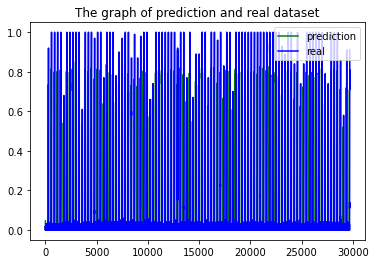

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch


data_list = list()

for i in range (1,100):
    with open (f'../datafile/datafile{i}.txt') as _f:
        data = _f.read().split('\n')
        _d = data[1:-1]
    
    data_list.extend(_d)

final_list = list()
for i in range (int(len(data_list)/100)):
    _d = data_list[100*(i-1) : 100*i]
    loss_packets = len([_data for _data in _d if _data == 'None'])
    final_list.append(loss_packets)
final_list = np.array(final_list)
print(len(final_list))


dataset = final_list.astype(np.float32)
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

def create_dataset(dataset, look_back=50):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

train_size = int(len(data_X) - 300)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

train_X = train_X.reshape(-1, 1, 50)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 50)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)

from torch import nn
from torch.autograd import Variable
test_loss = list()
class lstm(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layer):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.dropout = nn.Dropout(0.5)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        x = self.dropout(x)
        s,b,h = x.size()
        x = x.view(s*b,h)
        x = self.layer2(x)
        x = x.view(s,b,-1)
        return x

model = lstm(50,4,1,3)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# 开始训练
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    pred = out.argmax(dim=1)

    num_correct = 1
    num_correct = torch.eq(pred, var_y).sum()
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 1 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
    test_loss.append(loss.item())

torch.save(model, './packetloss_net.pkl')
    
model = model.eval() # 转换成测试模式

data_X = data_X.reshape(-1, 1, 50)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = model(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()
# 画出实际结果和预测的结果
plt.plot(pred_test, 'g', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')
plt.title('The graph of prediction and real dataset')
plt.show()



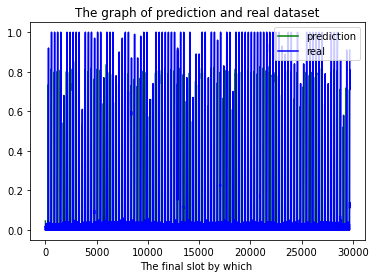

<Figure size 432x288 with 0 Axes>

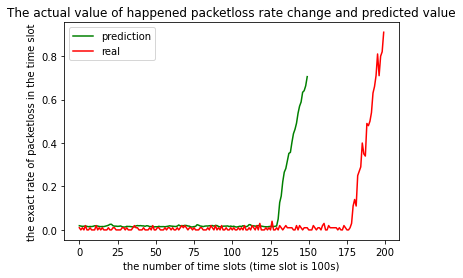

In [9]:
from matplotlib import pyplot as plt
plt.plot(pred_test, 'g', label='prediction')
plt.plot(dataset, 'b', label='real')

plt.legend(loc='best')
plt.title('The graph of prediction and real dataset')
plt.xlabel('The final slot by which ')
plt.show()

plt.figure()
y = pred_test[29500: 29700].tolist()
_y = dataset[29500: 29700]
x = np.arange(0,150).tolist()
_x = np.arange(0,200).tolist()
plt.figure()
plt.plot(x, y, 'g', label='prediction')
plt.plot(_x, _y, 'r', label='real')
plt.legend(loc = 'best')
plt.title('\
The actual value of happened packet\
loss rate change and predicted value'
)
plt.xlabel('the number of time slots (time slot is 100s)')
plt.ylabel('the exact rate of packetloss in the time slot')
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


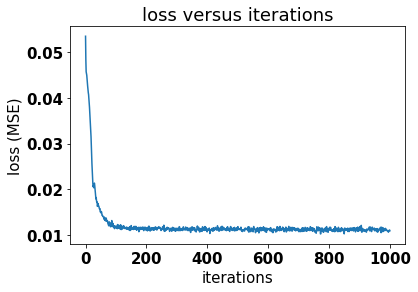

In [22]:
plt.plot(test_loss)
font = {'size' : 15}
import matplotlib

plt.xlabel('iterations')
plt.title('loss versus iterations')
plt.ylabel('loss (MSE)')
matplotlib.rc('font', **font)


In [79]:
model_pkloss = torch.load('./packetloss_net.pkl')

In [80]:
with open (f'../datafile/datafile{200}.txt') as _f:
        data = _f.read().split('\n')
        data_200 = data[1:-1]

In [81]:
final_200 = list()
for i in range (int(len(data_200)/100)):
    _d = data_200[100*(i-1) : 100*i]
    loss_packets = len([_data for _data in _d if _data == 'None'])
    final_200.append(loss_packets)
final_200 = np.array(final_200)

In [82]:
dataset_200 = final_200.astype(np.float32)
max_value = np.max(dataset_200)
min_value = np.min(dataset_200)
scalar = max_value - min_value
dataset_200 = list(map(lambda x: x / scalar, dataset_200))

In [83]:
X, Y = create_dataset(dataset_200)

In [84]:
model_pkloss.eval()

lstm(
  (layer1): LSTM(50, 4, num_layers=3)
  (dropout): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)

In [85]:
X =X.reshape(-1, 1, 50)
data_200 = torch.from_numpy(X)
var_200 = Variable(data_200)
pred_test = model(var_200)

In [87]:
len(dataset_200)
pred_test = pred_test.view(-1).data.numpy()

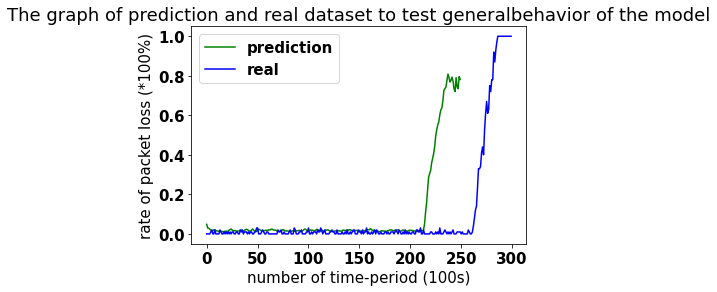

In [90]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'g', label='prediction')
plt.plot(dataset_200, 'b', label='real')
plt.legend(loc='best')
plt.title('The graph of prediction and real dataset to test general\
behavior of the model')
plt.xlabel('number of time-period (100s)')
plt.ylabel('rate of packet loss (*100%)')
plt.show()